# Statistical Models

## ARIMA

In [214]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
file_path = 'SP500_Last_10_Years.csv'
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
data.index = pd.DatetimeIndex(data.index).to_period('D')

In [215]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-04-21,1865.790039,1871.890015,1863.180054,1871.890015,1871.890015,2642500000
2014-04-22,1872.569946,1884.890015,1872.569946,1879.550049,1879.550049,3215440000
2014-04-23,1879.319946,1879.750000,1873.910034,1875.390015,1875.390015,3085720000
2014-04-24,1881.969971,1884.060059,1870.239990,1878.609985,1878.609985,3191830000
2014-04-25,1877.719971,1877.719971,1859.699951,1863.400024,1863.400024,3213020000


In [216]:


# Create the differenced series to make the data stationary
data['Open_diff'] = data['Open'].diff().dropna()

# Split the data into train and test datasets
split_date = '2022-04-01'
train_diff = data.loc[data.index < split_date, 'Open_diff']
test_diff = data.loc[data.index >= split_date, 'Open_diff']
train = data.loc[data.index < split_date, 'Open']
test = data.loc[data.index >= split_date, 'Open']

In [217]:
result_diff = adfuller(data['Open'].dropna())
adf_statistic_diff, p_value_diff, _, _, critical_values_diff, _ = result_diff
adf_statistic_diff, p_value_diff

(-0.12231874084049461, 0.9471696247168877)

The Augmented Dickey-Fuller test results indicate that the series is not stationary (with a p-value of 0.968, which is much greater than 0.05). We need to difference the data to achieve stationarity.

The differenced data shows a test statistic of -47.55, which is well below the critical values, and a p-value of 0. This confirms that the first-differenced series is stationary.

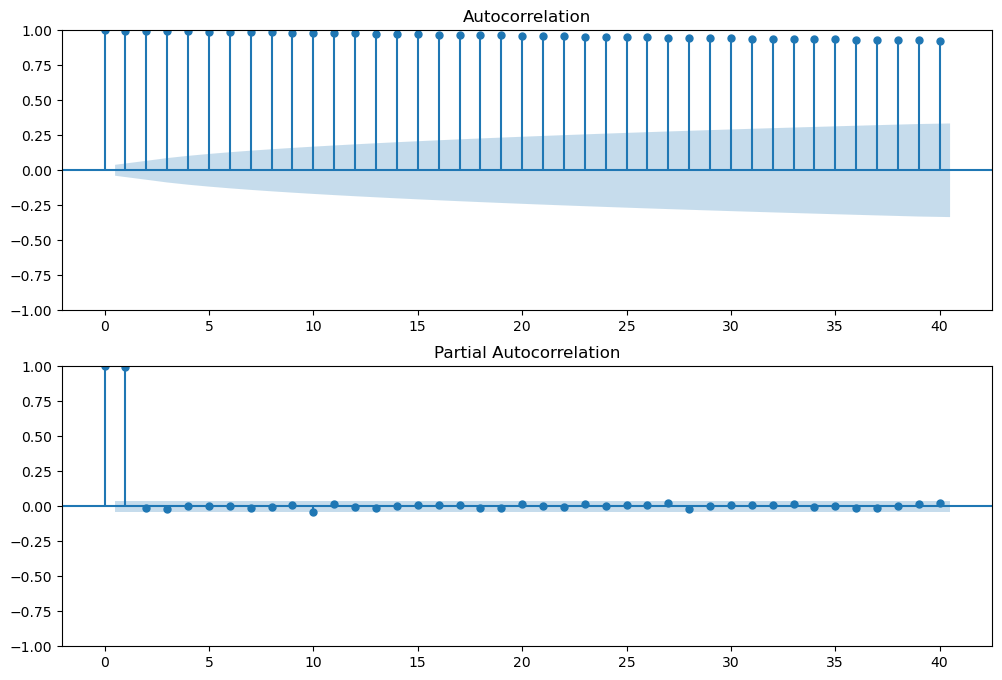

In [218]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['Open'], lags=40, ax=ax1)
plot_pacf(data['Open'], lags=40, ax=ax2)

plt.show()

Based on the ACF and PACF plots:

The PACF plot shows a sharp cut-off after the first lag, suggesting p=1.
The ACF plot tails off, which indicates an MA component. The first few lags beyond the first are significant but quickly become insignificant, suggesting q=1.

In [219]:
print(train_diff)

Date
2014-04-21          NaN
2014-04-22     6.779907
2014-04-23     6.750000
2014-04-24     2.650024
2014-04-25    -4.250000
                ...    
2022-03-25    52.930176
2022-03-28    18.179688
2022-03-29    61.770020
2022-03-30    21.340332
2022-03-31   -25.180176
Freq: D, Name: Open_diff, Length: 2003, dtype: float64


In [220]:
# Fit the SARIMA model on the differenced data
model_diff = SARIMAX(train_diff, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results_diff = model_diff.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79799D+00    |proj g|=  1.11995D-01

At iterate    5    f=  4.74627D+00    |proj g|=  1.18313D-02

At iterate   10    f=  4.73063D+00    |proj g|=  2.38554D-03

At iterate   15    f=  4.72937D+00    |proj g|=  4.73882D-04

At iterate   20    f=  4.72928D+00    |proj g|=  1.55951D-05


 This problem is unconstrained.



At iterate   25    f=  4.72928D+00    |proj g|=  1.50389D-04

At iterate   30    f=  4.72928D+00    |proj g|=  3.93294D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     35      1     0     0   3.933D-06   4.729D+00
  F =   4.7292802925639528     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [221]:
# Perform dynamic predictions on the differenced data
dynamic_predictions_diff = results_diff.get_prediction(start=test_diff.index[0], end=test_diff.index[-1], dynamic=True)
predicted_diff_values = dynamic_predictions_diff.predicted_mean

/Users/ahmadshahzad/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [222]:
print(predicted_diff_values)

2022-04-01    1.381432
2022-04-02    1.381432
2022-04-03    1.381432
2022-04-04    1.381432
2022-04-05    1.381432
                ...   
2024-04-13    1.381432
2024-04-14    1.381432
2024-04-15    1.381432
2024-04-16    1.381432
2024-04-17    1.381432
Freq: D, Name: predicted_mean, Length: 748, dtype: float64


In [223]:
# Reintegrate the differences to convert predictions back to the original scale
last_known_value = train.iloc[-1]
reintegrated_predictions = last_known_value + predicted_diff_values.cumsum()

In [224]:
predicted_diff_values

2022-04-01    1.381432
2022-04-02    1.381432
2022-04-03    1.381432
2022-04-04    1.381432
2022-04-05    1.381432
                ...   
2024-04-13    1.381432
2024-04-14    1.381432
2024-04-15    1.381432
2024-04-16    1.381432
2024-04-17    1.381432
Freq: D, Name: predicted_mean, Length: 748, dtype: float64

In [225]:
# Ensure that the reintegrated predictions have the correct index and alignment
reintegrated_predictions_series = pd.Series(reintegrated_predictions, index=test_diff.index)
common_index = reintegrated_predictions_series.index.intersection(test.index)
reintegrated_common = reintegrated_predictions_series[common_index]
test_common = test[common_index]

In [226]:
reintegrated_common

Date
2022-04-01    4600.401452
2022-04-04    4604.545749
2022-04-05    4605.927182
2022-04-06    4607.308614
2022-04-07    4608.690046
                 ...     
2024-04-11    5624.042876
2024-04-12    5625.424308
2024-04-15    5629.568605
2024-04-16    5630.950038
2024-04-17    5632.331470
Freq: D, Name: predicted_mean, Length: 513, dtype: float64

In [227]:
# Calculate RMSE between the reintegrated predicted and actual values on the original scale

rmse_dynamic_reintegrated = np.sqrt(mean_squared_error(test_common, reintegrated_common))
residuals = test_common - reintegrated_common


rmse_dynamic_reintegrated


875.8396930704871

In [228]:
from sklearn.metrics import r2_score

# Calculate the R^2 score
r2_dynamic_reintegrated = r2_score(test_common, reintegrated_common)
r2_dynamic_reintegrated

-3.811473165841454

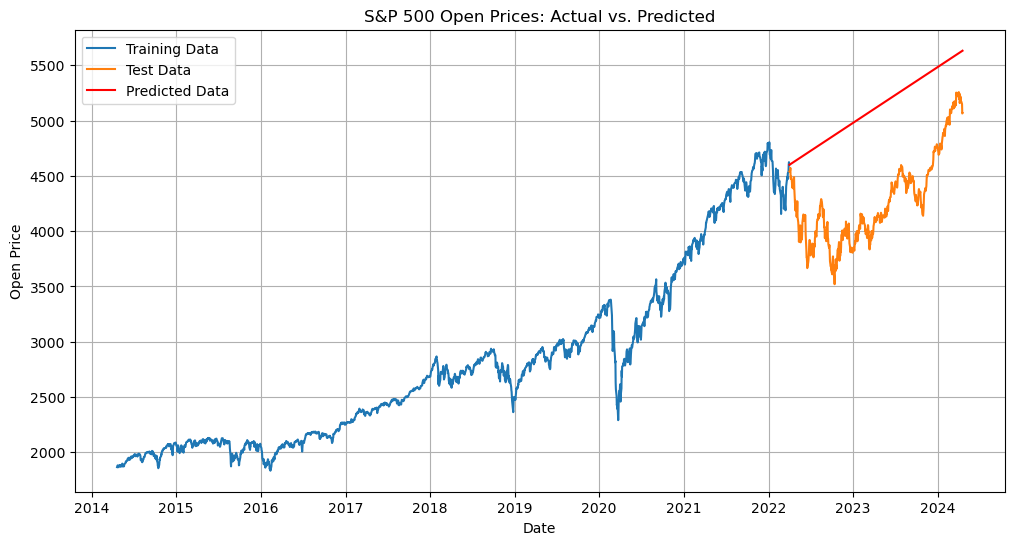

Dynamic Forecasting RMSE: 875.8396930704871


In [229]:
# Convert PeriodIndex to DatetimeIndex for plotting
train.index = train.index.to_timestamp()
test.index = test.index.to_timestamp()
reintegrated_common.index = reintegrated_common.index.to_timestamp()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(reintegrated_common.index, reintegrated_common, label='Predicted Data', color='red')
plt.title('S&P 500 Open Prices: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)

plt.show()

# Print RMSE result
print("Dynamic Forecasting RMSE:", rmse_dynamic_reintegrated)


## EWMA

In [210]:
import pandas as pd

# Load the data
file_path = 'SP500_Last_10_Years.csv'
sp500_data = pd.read_csv(file_path)

# Display the first few rows and the data types to understand its structure
sp500_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-04-21,1865.790039,1871.890015,1863.180054,1871.890015,1871.890015,2642500000
1,2014-04-22,1872.569946,1884.890015,1872.569946,1879.550049,1879.550049,3215440000
2,2014-04-23,1879.319946,1879.750000,1873.910034,1875.390015,1875.390015,3085720000
3,2014-04-24,1881.969971,1884.060059,1870.239990,1878.609985,1878.609985,3191830000
4,2014-04-25,1877.719971,1877.719971,1859.699951,1863.400024,1863.400024,3213020000


In [211]:
sp500_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2516 non-null   object 
 1   Open       2516 non-null   float64
 2   High       2516 non-null   float64
 3   Low        2516 non-null   float64
 4   Close      2516 non-null   float64
 5   Adj Close  2516 non-null   float64
 6   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.7+ KB


In [201]:
from pandas.tseries.offsets import DateOffset

# Convert Date to datetime and set as index
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

# Sort data by date just in case
sp500_data.sort_index(inplace=True)

# Split the data
# Calculate the cutoff date: 8 years for training and 2 years for testing
cutoff_date = sp500_data.index.max() - DateOffset(years=2)

# Training and testing datasets
train_data = sp500_data.loc[sp500_data.index <= cutoff_date]
test_data = sp500_data.loc[sp500_data.index > cutoff_date]

# Check the splitting by showing the last entries of train and first entries of test
train_data.tail(), test_data.head()


(                   Open         High          Low        Close    Adj Close  \
 Date                                                                          
 2022-04-08  4494.149902  4520.410156  4474.600098  4488.279785  4488.279785   
 2022-04-11  4462.640137  4464.350098  4408.379883  4412.529785  4412.529785   
 2022-04-12  4437.589844  4471.000000  4381.339844  4397.450195  4397.450195   
 2022-04-13  4394.299805  4453.919922  4392.700195  4446.589844  4446.589844   
 2022-04-14  4449.120117  4460.459961  4390.770020  4392.589844  4392.589844   
 
                 Volume  
 Date                    
 2022-04-08  4083200000  
 2022-04-11  4266290000  
 2022-04-12  4152090000  
 2022-04-13  3828150000  
 2022-04-14  4083090000  ,
                    Open         High          Low        Close    Adj Close  \
 Date                                                                          
 2022-04-18  4385.629883  4410.310059  4370.299805  4391.689941  4391.689941   
 2022-04-19  43

/var/folders/yf/v21phsjd5yl5vny6rdj1p6n80000gn/T/ipykernel_9107/3574685699.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['EWM'] = train_data['Open'].ewm(span=span, adjust=False).mean()
/var/folders/yf/v21phsjd5yl5vny6rdj1p6n80000gn/T/ipykernel_9107/3574685699.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Open'] = predictions


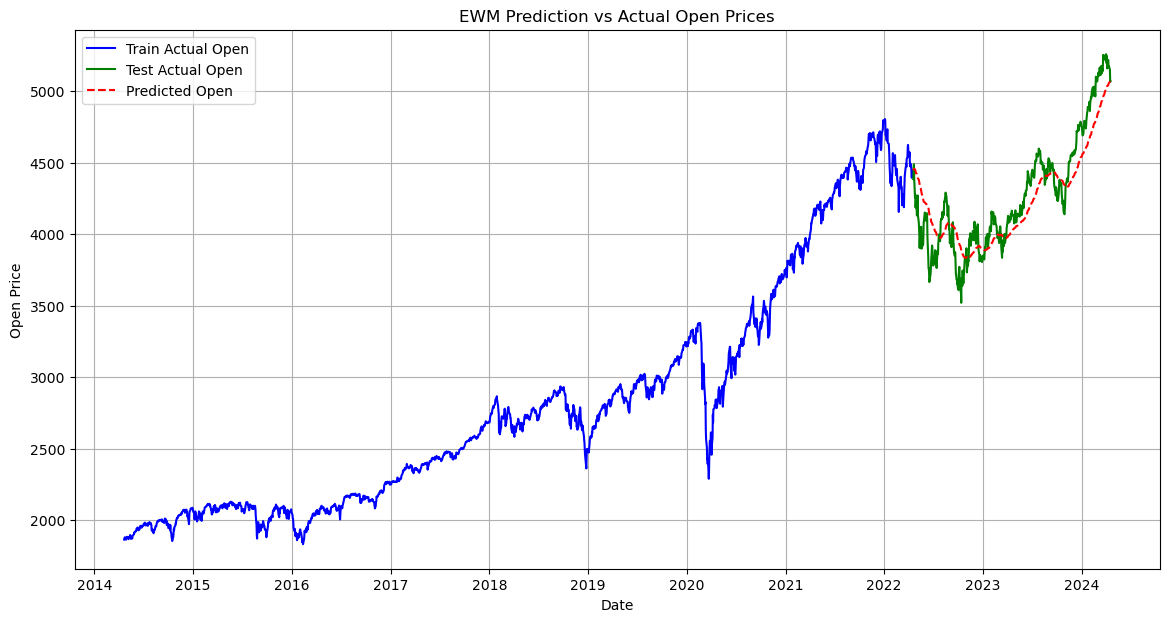

(172.5898224796284, 0.8157335835732201)

In [202]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Set the span for the EWM
span = 30  # Arbitrary choice, can be adjusted for sensitivity analysis

# Calculate the EWM of the open prices on the training data
train_data['EWM'] = train_data['Open'].ewm(span=span, adjust=False).mean()

# We use the last EWM value as the predictor for the first value in the test set and continue from there
predictions = [train_data['EWM'].iloc[-1]]
for i in range(1, len(test_data)):
    # Update the prediction to be the previous predicted EWM value (like a rolling forecast)
    new_pred = predictions[-1] + (test_data['Open'].iloc[i-1] - predictions[-1]) / span
    predictions.append(new_pred)

# Add predictions to the test data for comparison
test_data['Predicted_Open'] = predictions

# Calculate RMSE and R2
rmse = np.sqrt(mean_squared_error(test_data['Open'], test_data['Predicted_Open']))
r2 = r2_score(test_data['Open'], test_data['Predicted_Open'])

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train_data['Open'], label='Train Actual Open', color='blue')
plt.plot(test_data['Open'], label='Test Actual Open', color='green')
plt.plot(test_data.index, test_data['Predicted_Open'], label='Predicted Open', color='red', linestyle='--')
plt.title('EWMA Prediction vs Actual Open Prices')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

rmse, r2


In [203]:
rmse,r2

(172.5898224796284, 0.8157335835732201)

In [206]:
peform_dict={}
peform_dict['models']=['ARIMA','EWM']
peform_dict["R2"]=[r2_dynamic_reintegrated,r2]

peform_dict['RMSE']=[rmse_dynamic_reintegrated,rmse]

In [207]:
import json
with open('stats_model_performance_results.json', 'w') as file:
    json.dump(peform_dict, file, indent=4)